In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Deep/trash_ICRA19.zip -d /content/drive/MyDrive/Deep/trash_ICRA19

In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import pandas as pd
import os

# تنظیمات اولیه
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# بارگذاری داده‌ها
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = F.to_tensor(Image.open(img_name).convert("RGB"))
        boxes = self.annotations.iloc[idx, 1:]  # فرض بر این است که مختصات جعبه‌ها در ستون‌های بعدی هستند
        boxes = torch.tensor(boxes.values).reshape(-1, 4)  # تبدیل به تنسور
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # فرض بر این است که همه اشیاء از یک کلاس هستند

        target = {'boxes': boxes, 'labels': labels}
        if self.transform:
            image = self.transform(image)

        return image, target

# تعریف مسیرها
img_dir = 'dataset/train/images'
annotations_file = 'dataset/train/annotations/labels.csv'

# ایجاد دیتاست و دataloader
dataset = CustomDataset(annotations_file, img_dir)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

# بارگذاری مدل Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # تعداد کلاس‌ها (شامل کلاس پس‌زمینه)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# انتقال مدل به دستگاه
model.to(device)

# تعریف بهینه‌ساز
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# آموزش مدل
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # صفر کردن گرادیان‌ها
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # محاسبه گرادیان و به‌روزرسانی وزن‌ها
        losses.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {losses.item()}')

# ذخیره مدل
torch.save(model.state_dict(), 'faster_rcnn_model.pth')

In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import pandas as pd
import os

# تنظیمات اولیه
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# بارگذاری داده‌ها
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = F.to_tensor(Image.open(img_name).convert("RGB"))
        boxes = self.annotations.iloc[idx, 1:]  # فرض بر این است که مختصات جعبه‌ها در ستون‌های بعدی هستند
        boxes = torch.tensor(boxes.values).reshape(-1, 4)  # تبدیل به تنسور
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # فرض بر این است که همه اشیاء از یک کلاس هستند

        target = {'boxes': boxes, 'labels': labels}
        if self.transform:
            image = self.transform(image)

        return image, target

# تعریف مسیرها
img_dir = 'dataset/train/images'
annotations_file = 'dataset/train/annotations/labels.csv'

# ایجاد دیتاست و دataloader
dataset = CustomDataset(annotations_file, img_dir)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

# بارگذاری مدل Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # تعداد کلاس‌ها (شامل کلاس پس‌زمینه)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# انتقال مدل به دستگاه
model.to(device)

# تعریف بهینه‌ساز
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# آموزش مدل
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # صفر کردن گرادیان‌ها
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # محاسبه گرادیان و به‌روزرسانی وزن‌ها
        losses.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {losses.item()}')

# ذخیره مدل
torch.save(model.state_dict(), 'faster_rcnn_model.pth')

In [ ]:
import sys
import os
import numpy as np
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from tqdm import tqdm
import shutil
import xmltodict
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from xml.dom.minidom import parseString
import pandas as pd
import xmltodict
import json


In [ ]:
import sys
import os
import numpy as np
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from tqdm import tqdm
import shutil
import xmltodict
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from xml.dom.minidom import parseString
import pandas as pd
import xmltodict
import json


In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/16_mmdet/lib")

In [ ]:
from infer_engine import Infer

In [ ]:
gtf = Infer();

In [ ]:
# Download trained model

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rsNMKHN2cn2kDUak2Gkz2A2qFNOlStzS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1rsNMKHN2cn2kDUak2Gkz2A2qFNOlStzS" -O obj_underwater_trash_trained.zip && rm -rf /tmp/cookies.txt

In [ ]:
! unzip -qq obj_underwater_trash_trained.zip

In [ ]:
gtf.Model_Params("work_dirs/config_updated/config_updated.py",
                 "work_dirs/config_updated/latest.pth")

In [ ]:
import os
img_list = os.listdir("dataset/test/images");

In [ ]:
os.system("cp dataset/test/images/" + img_list[850] + " work_dirs/test/4.jpg");

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/1.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.06847333908081055 sec
Saving Time: 0.005776166915893555 sec


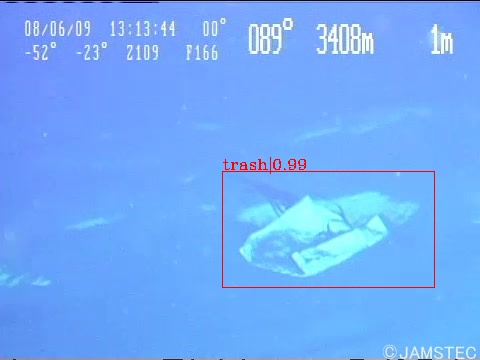

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/2.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.06426095962524414 sec
Saving Time: 0.006548404693603516 sec


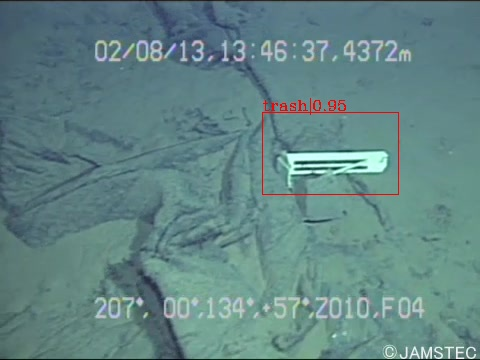

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/3.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.06453537940979004 sec
Saving Time: 0.0061495304107666016 sec


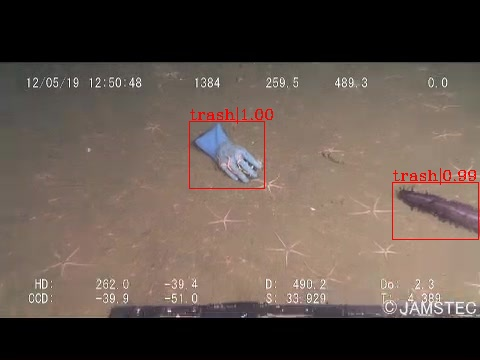

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/4.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.06491804122924805 sec
Saving Time: 0.005884885787963867 sec


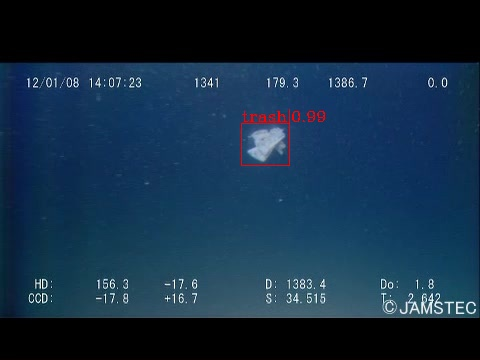

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/5.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.06511974334716797 sec
Saving Time: 0.0060007572174072266 sec


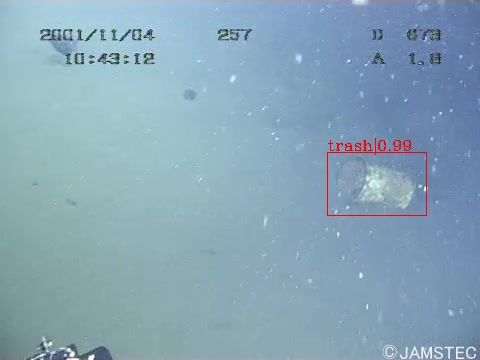

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/6.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.06580185890197754 sec
Saving Time: 0.005091428756713867 sec


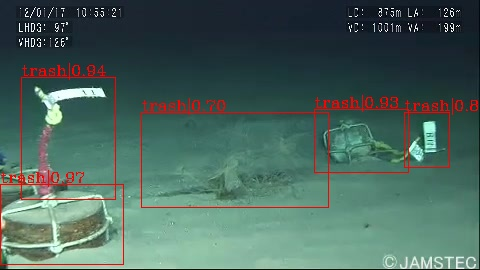

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/7.jpg",
           out_img_path="result.jpg",
           thresh=0.65);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.06950831413269043 sec
Saving Time: 0.005250453948974609 sec


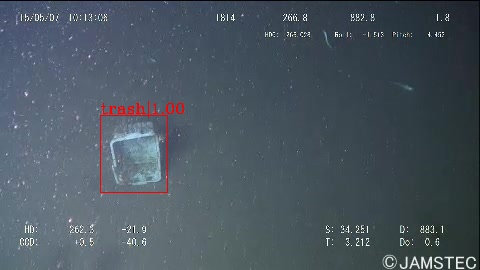

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/8.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.0640249252319336 sec
Saving Time: 0.005843400955200195 sec


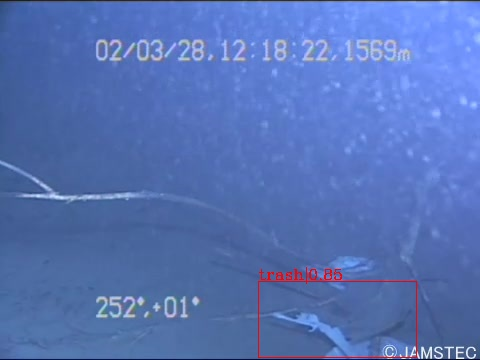

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/9.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.06330275535583496 sec
Saving Time: 0.0056226253509521484 sec


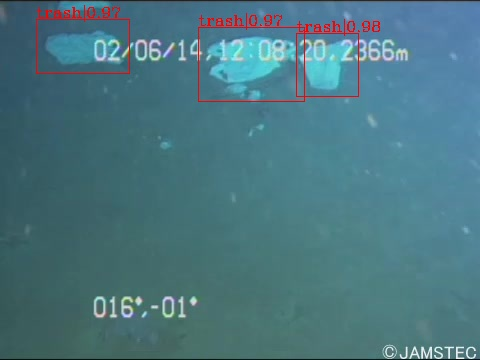

In [ ]:
result = gtf.Predict(img_path="work_dirs/test/10.jpg",
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

# Training your own detector

## Dataset
 - Credits: https://conservancy.umn.edu/handle/11299/214366

In [ ]:
! wget https://conservancy.umn.edu/bitstream/handle/11299/214366/trash_ICRA19.zip

In [ ]:
! unzip -qq trash_ICRA19.zip

In [ ]:
ls trash_ICRA19/dataset/

README.txt*  test/  train/  val/  videos_for_testing/


In [ ]:
! mkdir dataset

! mkdir dataset/train
! mkdir dataset/train/images
! mkdir dataset/train/xml_anno

! mkdir dataset/val
! mkdir dataset/val/images
! mkdir dataset/val/xml_anno

! mkdir dataset/test
! mkdir dataset/test/images
! mkdir dataset/test/xml_anno

In [ ]:
! cp trash_ICRA19/dataset/train/*.jpg dataset/train/images/
! cp trash_ICRA19/dataset/train/*.xml dataset/train/xml_anno/

In [ ]:
! cp trash_ICRA19/dataset/val/*.jpg dataset/val/images/
! cp trash_ICRA19/dataset/val/*.xml dataset/val/xml_anno/

In [ ]:
! cp trash_ICRA19/dataset/test/*.jpg dataset/test/images/
! cp trash_ICRA19/dataset/test/*.xml dataset/test/xml_anno/

In [ ]:
! pip install xmltodict tqdm dicttoxml

# Data Conversion from current format to COCO Format

# Current Format

## Dataset Directory Structure

       Dataset (root_dir)
          |
          |-----------Images (img_dir)
          |              |
          |              |------------------img1.jpg
          |              |------------------img2.jpg
          |              |------------------.........(and so on)
          |
          |
          |-----------Annotations (anno_dir)
          |              |
          |              |------------------img1.xml
          |              |------------------img2.xml
          |              |------------------.........(and so on)

# COCO Format

## Dataset Directory Structure

       Dataset (root_dir)
          |
          |
          |
          |---Images (img_dir)
          |----|
               |-------------------img1.jpg
               |-------------------img2.jpg
               |-------------------.........(and so on)


          |---annotations (anno_dir)
          |----|
               |--------------------instances_Images.json
               |--------------------classes.txt
          
          
 - instances_Images.json -> In proper COCO format
 - classes.txt          -> A list of classes in alphabetical order

In [ ]:
import os
import sys
import numpy as np
import pandas as pd

import xmltodict
import json
from tqdm.notebook import tqdm

from pycocotools.coco import COCO

root_dir = "dataset/train/";
img_dir = "images/";
anno_dir = "xml_anno/";

files = os.listdir(root_dir + anno_dir);

combined = [];
total_timestamp = 0;
for i in tqdm(range(len(files))):
    annoFile = root_dir + "/" + anno_dir + "/" + files[i];
    f = open(annoFile, 'r');
    my_xml = f.read();
    anno = dict(dict(xmltodict.parse(my_xml))["annotation"])
    fname = anno["filename"];
    label_str = "";
    if(type(anno["object"]) == list):
        for j in range(len(anno["object"])):
            obj = dict(anno["object"][j]);
            label = anno["object"][j]["name"];
            if(label == "timestamp"):
                continue
            label = "trash";
            bbox = dict(anno["object"][j]["bndbox"])
            x1 = bbox["xmin"];
            y1 = bbox["ymin"];
            x2 = bbox["xmax"];
            y2 = bbox["ymax"];
            if(j == len(anno["object"])-1):
                label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;
            else:
                label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label + " ";
    else:
        obj = dict(anno["object"]);#
        label = anno["object"]["name"];
        if(label == "timestamp"):
            continue
        label = "trash";
        bbox = dict(anno["object"]["bndbox"])
        x1 = bbox["xmin"];
        y1 = bbox["ymin"];
        x2 = bbox["xmax"];
        y2 = bbox["ymax"];

        label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;


    combined.append([fname, label_str])

df = pd.DataFrame(combined, columns = ['ID', 'Label']);
df.to_csv(root_dir + "/labels.csv", index=False);

In [ ]:
import os
import numpy as np
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

root = "dataset/train/";
img_dir = "images/";
anno_file = "labels.csv";

dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)

input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

df = pd.read_csv(input_annotations_path);
columns = df.columns

delimiter = " ";

list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
print(anno)

for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);


    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

  1%|          | 50/5720 [00:00<00:11, 492.35it/s]

['trash']


100%|██████████| 5720/5720 [00:11<00:00, 487.98it/s]


In [ ]:
import os
import sys
import numpy as np
import pandas as pd

import xmltodict
import json
from tqdm.notebook import tqdm

from pycocotools.coco import COCO

root_dir = "dataset/val/";
img_dir = "images/";
anno_dir = "xml_anno/";

files = os.listdir(root_dir + anno_dir);

combined = [];
total_timestamp = 0;
for i in tqdm(range(len(files))):
    annoFile = root_dir + "/" + anno_dir + "/" + files[i];
    f = open(annoFile, 'r');
    my_xml = f.read();
    anno = dict(dict(xmltodict.parse(my_xml))["annotation"])
    fname = anno["filename"];
    label_str = "";
    if("object" in anno.keys()):
        if(type(anno["object"]) == list):
            for j in range(len(anno["object"])):
                obj = dict(anno["object"][j]);
                label = anno["object"][j]["name"];
                if(label == "timestamp"):
                    continue
                label = "trash";
                bbox = dict(anno["object"][j]["bndbox"])
                x1 = bbox["xmin"];
                y1 = bbox["ymin"];
                x2 = bbox["xmax"];
                y2 = bbox["ymax"];
                if(j == len(anno["object"])-1):
                    label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;
                else:
                    label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label + " ";
        else:
            obj = dict(anno["object"]);
            label = anno["object"]["name"];
            if(label == "timestamp"):
                continue
            label = "trash";
            bbox = dict(anno["object"]["bndbox"])
            x1 = bbox["xmin"];
            y1 = bbox["ymin"];
            x2 = bbox["xmax"];
            y2 = bbox["ymax"];

            label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;


        combined.append([fname, label_str])

df = pd.DataFrame(combined, columns = ['ID', 'Label']);
df.to_csv(root_dir + "/labels.csv", index=False);

In [ ]:
import os
import numpy as np
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

root = "dataset/val/";
img_dir = "images/";
anno_file = "labels.csv";

dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)

input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

df = pd.read_csv(input_annotations_path);
columns = df.columns

delimiter = " ";

list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
print(anno)

for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);


    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

  6%|▌         | 50/819 [00:00<00:01, 496.50it/s]

['trash']


100%|██████████| 819/819 [00:01<00:00, 499.52it/s]


In [ ]:
import os
import sys
import numpy as np
import pandas as pd

import xmltodict
import json
from tqdm.notebook import tqdm

from pycocotools.coco import COCO

root_dir = "dataset/test/";
img_dir = "images/";
anno_dir = "xml_anno/";

files = os.listdir(root_dir + anno_dir);

combined = [];
total_timestamp = 0;
for i in tqdm(range(len(files))):
    annoFile = root_dir + "/" + anno_dir + "/" + files[i];
    f = open(annoFile, 'r');
    my_xml = f.read();
    anno = dict(dict(xmltodict.parse(my_xml))["annotation"])
    fname = anno["filename"];
    label_str = "";
    if("object" in anno.keys()):
        if(type(anno["object"]) == list):
            for j in range(len(anno["object"])):
                obj = dict(anno["object"][j]);
                label = anno["object"][j]["name"];
                if(label == "timestamp"):
                    continue
                label = "trash";
                bbox = dict(anno["object"][j]["bndbox"])
                x1 = bbox["xmin"];
                y1 = bbox["ymin"];
                x2 = bbox["xmax"];
                y2 = bbox["ymax"];
                if(j == len(anno["object"])-1):
                    label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;
                else:
                    label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label + " ";
        else:
            obj = dict(anno["object"]);
            label = anno["object"]["name"];
            if(label == "timestamp"):
                continue
            label = "trash";
            bbox = dict(anno["object"]["bndbox"])
            x1 = bbox["xmin"];
            y1 = bbox["ymin"];
            x2 = bbox["xmax"];
            y2 = bbox["ymax"];

            label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;


        combined.append([fname, label_str])

df = pd.DataFrame(combined, columns = ['ID', 'Label']);
df.to_csv(root_dir + "/labels.csv", index=False);

In [ ]:
import os
import numpy as np
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

root = "dataset/test/";
img_dir = "images/";
anno_file = "labels.csv";

dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)

input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

df = pd.read_csv(input_annotations_path);
columns = df.columns

delimiter = " ";

list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
print(anno)

for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);


    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

  4%|▍         | 51/1145 [00:00<00:02, 507.55it/s]

['trash']


100%|██████████| 1145/1145 [00:02<00:00, 486.55it/s]


# Training

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/16_mmdet/lib")

In [ ]:
from train_engine import Detector

In [ ]:
gtf = Detector();

In [ ]:
img_dir = "dataset/train/images";
annofile = "dataset/train/annotations/instances_images.json"
class_file = "dataset/train/annotations/classes.txt"

gtf.Train_Dataset(img_dir, annofile, class_file);

In [ ]:
img_dir = "dataset/val/images";
annofile = "dataset/val/annotations/instances_images.json"

gtf.Val_Dataset(img_dir, annofile);

In [ ]:
gtf.Dataset_Params(batch_size=8, num_workers=4)

In [ ]:
gtf.List_Models();

1. Model - faster_rcnn_fpn50
2. Model - faster_rcnn_fpn101
3. Model - faster_rcnn_x101_32x4d_fpn
4. Model - faster_rcnn_x101_64x4d_fpn
5. Model - cascade_rcnn_fpn50
6. Model - cascade_rcnn_fpn101
7. Model - cascade_rcnn_x101_32x4d_fpn
8. Model - cascade_rcnn_x101_64x4d_fpn
9. Model - retinanet_r50_fpn
10. Model - retinanet_r101_fpn
11. Model - retinanet_x101_32x4d_fpn
12. Model - retinanet_x101_64x4d_fpn
13. Model - retinanet_ghm_r50_fpn
14. Model - retinanet_ghm_r101_fpn
15. Model - retinanet_ghm_x101_32x4d_fpn
16. Model - retinanet_ghm_x101_64x4d_fpn
17. Model - dh_faster_rcnn_fpn50
18. Model - libra_faster_rcnn_fpn50
19. Model - libra_faster_rcnn_fpn101
20. Model - libra_faster_rcnn_x101_64x4d_fpn
21. Model - libra_retinanet_r50_fpn
22. Model - ga_faster_rcnn_x101_32x4d_fpn
23. Model - ga_faster_rcnn_x101_64x4d_fpn
24. Model - ga_retinanet_x101_32x4d_fpn
25. Model - ga_retinanet_x101_64x4d_fpn
26. Model - fovea_r50_fpn_4x4
27. Model - fovea_r101_fpn_4x4
28. Model - fovea_align_r50_f

In [ ]:
gtf.Model_Params(model_name="retinanet_r50_fpn");

In [ ]:
gtf.Hyper_Params(lr=0.02, momentum=0.9, weight_decay=0.0001);

In [ ]:
gtf.Training_Params(num_epochs=2, val_interval=1);

In [ ]:
gtf.Train();

2020-08-25 14:15:36,174 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.6.9 (default, Jul 17 2020, 12:50:27) [GCC 8.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda-10.0
NVCC: Cuda compilation tools, release 10.0, V10.0.130
GPU 0: Tesla V100-SXM2-16GB
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.4.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37

2020-08-25 14:15:36,873 - mmdet - INFO - load model from: torchvision://resnet50
2020-08-25 14:15:37,105 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


2020-08-25 14:15:41,556 - mmdet - INFO - load checkpoint from https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth
2020-08-25 14:15:41,692 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([9, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([9]).
2020-08-25 14:15:41,698 - mmdet - INFO - Start running, host: ubuntu@ip-172-31-11-76, work_dir: /home/ubuntu/Desktop/underwater_trash/work_dirs/config_updated
2020-08-25 14:15:41,699 - mmdet - INFO - workflow: [('train', 1)], max: 2 epochs


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2020-08-25 14:16:21,080 - mmdet - INFO - Epoch [1][50/715]	lr: 1.978e-03, eta: 0:18:01, time: 0.784, data_time: 0.074, memory: 10509, loss_cls: 0.6871, loss_bbox: 0.4716, loss: 1.1586
2020-08-25 14:16:58,225 - mmdet - INFO - Epoch [1][100/715]	lr: 3.976e-03, eta: 0:16:55, time: 0.743, data_time: 0.025, memory: 10509, loss_cls: 0.2843, loss_bbox: 0.3525, loss: 0.6367
2020-08-25 14:17:35,207 - mmdet - INFO - Epoch [1][150/715]	lr: 5.974e-03, eta: 0:16:07, time: 0.740, data_time: 0.025, memory: 10509, loss_cls: 0.2461, loss_bbox: 0.3279, loss: 0.5740
2020-08-25 14:18:12,200 - mmdet - INFO - Epoch [1][200/715]	lr: 7.972e-03, eta: 0:15:24, time: 0.740, data_time: 0.025, memory: 10509, loss_cls: 0.2310, loss_bbox: 0.3089, loss: 0.5399
2020-08-25 14:18:48,664 - mmdet - INFO - Epoch [1][250/715]	lr: 9.970e-03, eta: 0:14:41, time: 0.729, data_time: 0.024, memory: 10509, loss_cls: 0.2247, loss_bbox: 0.3100, loss: 0.5348
2020-08-25 14:19:25,219 - mmdet - INFO - Epoch [1][300/715]	lr: 1.197e-02, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 20.2 task/s, elapsed: 41s, ETA:     0s

2020-08-25 14:25:10,782 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.53s).
Accumulating evaluation results...


2020-08-25 14:25:19,994 - mmdet - INFO - Epoch [1][715/715]	lr: 2.000e-02, bbox_mAP: 0.3010, bbox_mAP_50: 0.5910, bbox_mAP_75: 0.2610, bbox_mAP_s: -1.0000, bbox_mAP_m: 0.3070, bbox_mAP_l: 0.3090, bbox_mAP_copypaste: 0.301 0.591 0.261 -1.000 0.307 0.309


DONE (t=1.07s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.591
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.261
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.307
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.309
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.517
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.517
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.527
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.505


2020-08-25 14:25:59,344 - mmdet - INFO - Epoch [2][50/715]	lr: 2.000e-03, eta: 0:08:02, time: 0.784, data_time: 0.074, memory: 10509, loss_cls: 0.1246, loss_bbox: 0.2113, loss: 0.3358
2020-08-25 14:26:36,110 - mmdet - INFO - Epoch [2][100/715]	lr: 2.000e-03, eta: 0:07:26, time: 0.735, data_time: 0.024, memory: 10509, loss_cls: 0.1019, loss_bbox: 0.1882, loss: 0.2901
2020-08-25 14:27:12,349 - mmdet - INFO - Epoch [2][150/715]	lr: 2.000e-03, eta: 0:06:50, time: 0.725, data_time: 0.026, memory: 10509, loss_cls: 0.1024, loss_bbox: 0.1883, loss: 0.2908
2020-08-25 14:27:49,073 - mmdet - INFO - Epoch [2][200/715]	lr: 2.000e-03, eta: 0:06:14, time: 0.734, data_time: 0.025, memory: 10509, loss_cls: 0.1054, loss_bbox: 0.1854, loss: 0.2908
2020-08-25 14:28:25,661 - mmdet - INFO - Epoch [2][250/715]	lr: 2.000e-03, eta: 0:05:37, time: 0.732, data_time: 0.026, memory: 10509, loss_cls: 0.0937, loss_bbox: 0.1761, loss: 0.2698
2020-08-25 14:29:02,257 - mmdet - INFO - Epoch [2][300/715]	lr: 2.000e-03, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 20.2 task/s, elapsed: 40s, ETA:     0s

2020-08-25 14:34:48,197 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.76s).
Accumulating evaluation results...


2020-08-25 14:34:52,703 - mmdet - INFO - Epoch [2][715/715]	lr: 2.000e-03, bbox_mAP: 0.3970, bbox_mAP_50: 0.6770, bbox_mAP_75: 0.4130, bbox_mAP_s: -1.0000, bbox_mAP_m: 0.3980, bbox_mAP_l: 0.3970, bbox_mAP_copypaste: 0.397 0.677 0.413 -1.000 0.398 0.397


DONE (t=0.48s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.397
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.677
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.413
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.398
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.397
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.543
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.543
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.536
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.552


# Run inference on images

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/16_mmdet/lib")

In [ ]:
from infer_engine import Infer

In [ ]:
gtf = Infer();

In [ ]:
gtf.Model_Params("work_dirs/config_updated/config_updated.py",
                 "work_dirs/config_updated/latest.pth")

In [ ]:
import os
img_list = os.listdir("dataset/test/images");

Inference Time: 0.07698702812194824 sec
Saving Time: 0.00562596321105957 sec


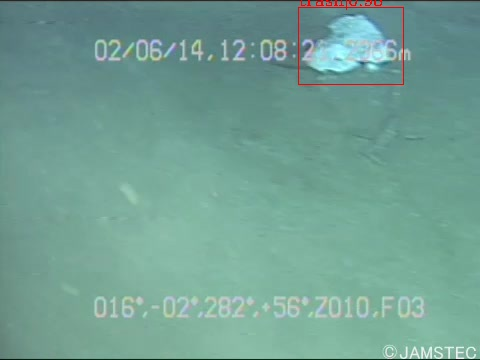

In [ ]:
result = gtf.Predict(img_path="dataset/test/images/" + img_list[0],
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)

Inference Time: 0.062406063079833984 sec
Saving Time: 0.005638599395751953 sec


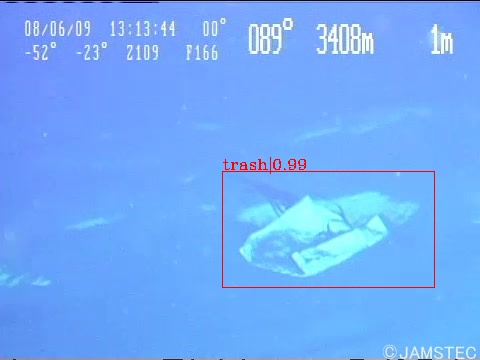

In [ ]:
result = gtf.Predict(img_path="dataset/test/images/" + img_list[5],
           out_img_path="result.jpg",
           thresh=0.8);

from IPython.display import Image
Image(filename='result.jpg', width=490, height=640)